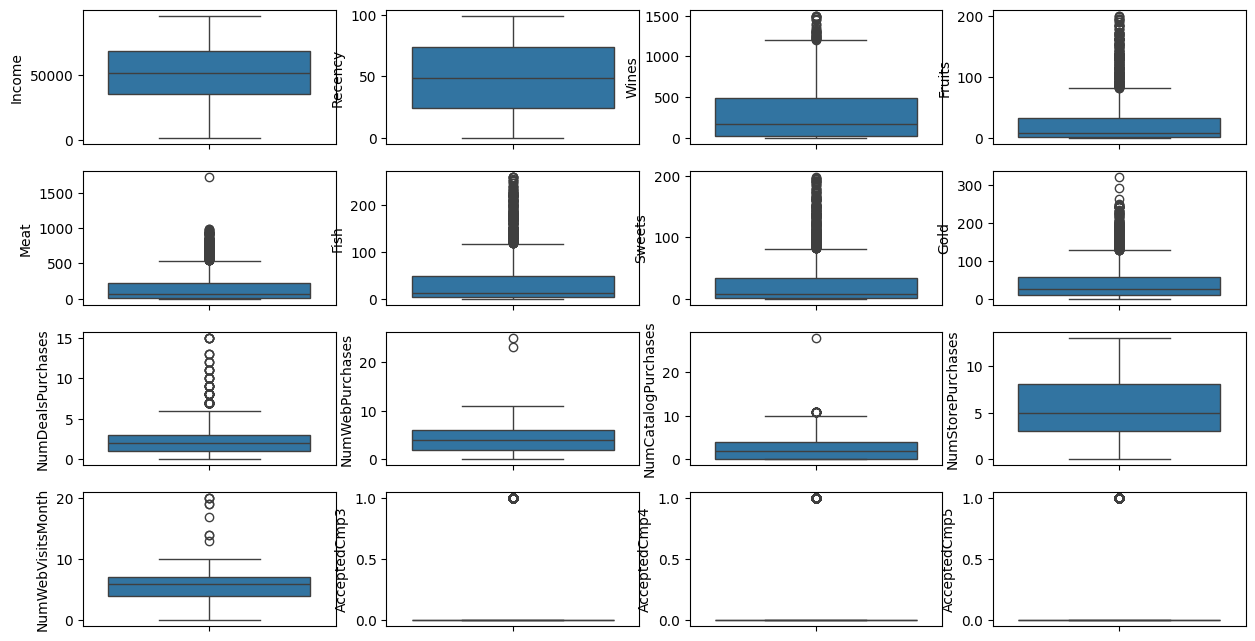

[[ 666.  927.    0.    2.]
 [  47.  695.    0.    2.]
 [ 535.  758.    0.    2.]
 [ 548.  827.    0.    2.]
 [ 675.  818.    0.    2.]
 [ 175.  977.    0.    2.]
 [ 100.  384.    0.    2.]
 [ 364. 1115.    0.    2.]
 [ 785.  928.    0.    2.]
 [  22.  329.    0.    2.]]


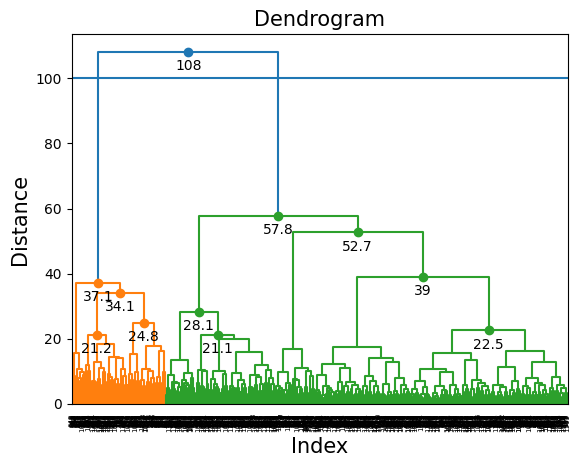

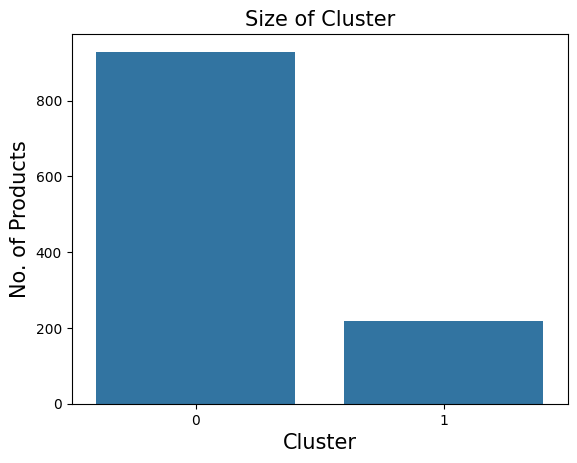

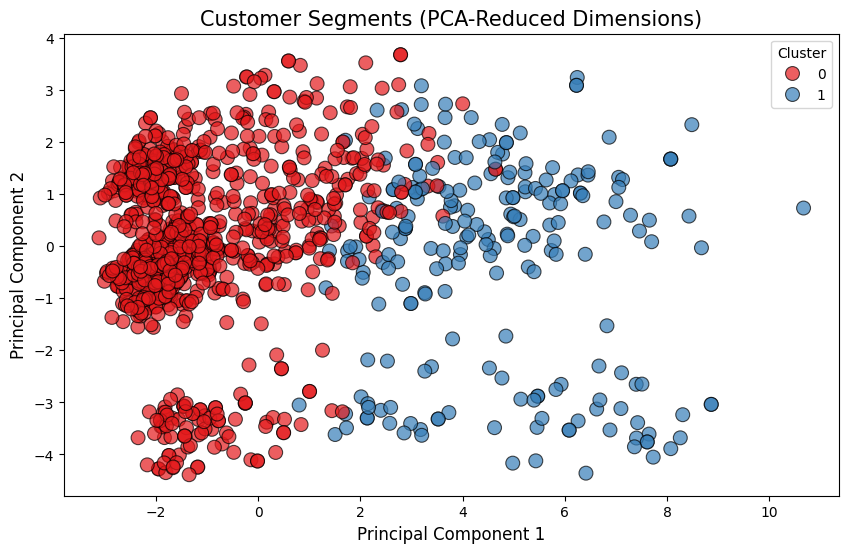

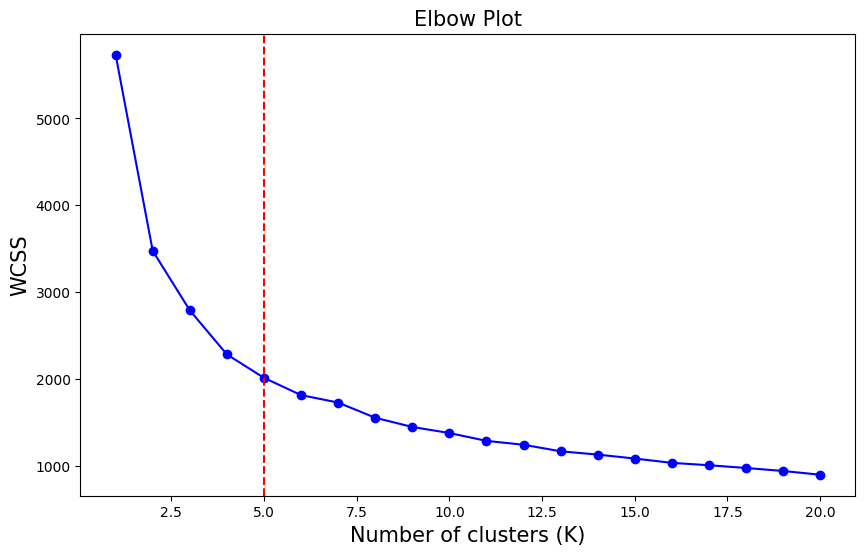

<ipython-input-7-d8abc8e38c8b>:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_num, x='Cluster', palette='Set1')


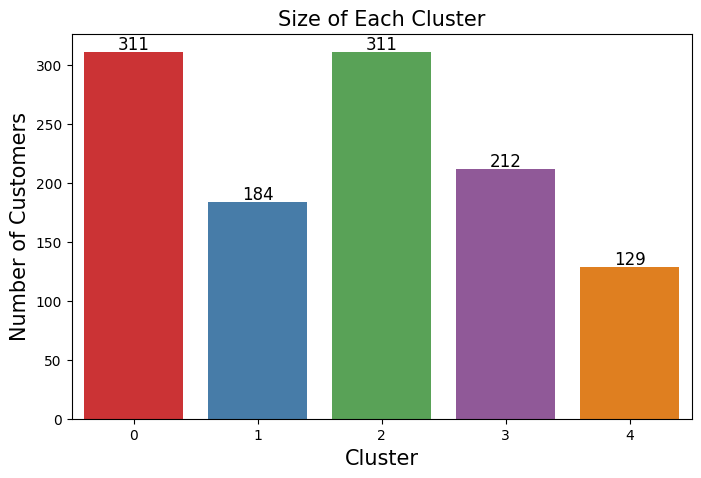

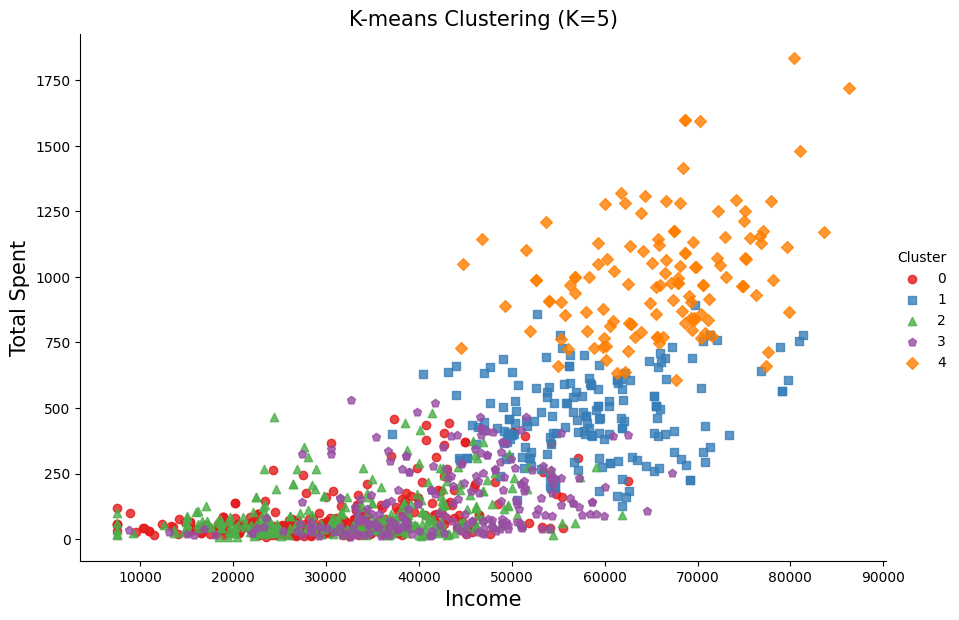

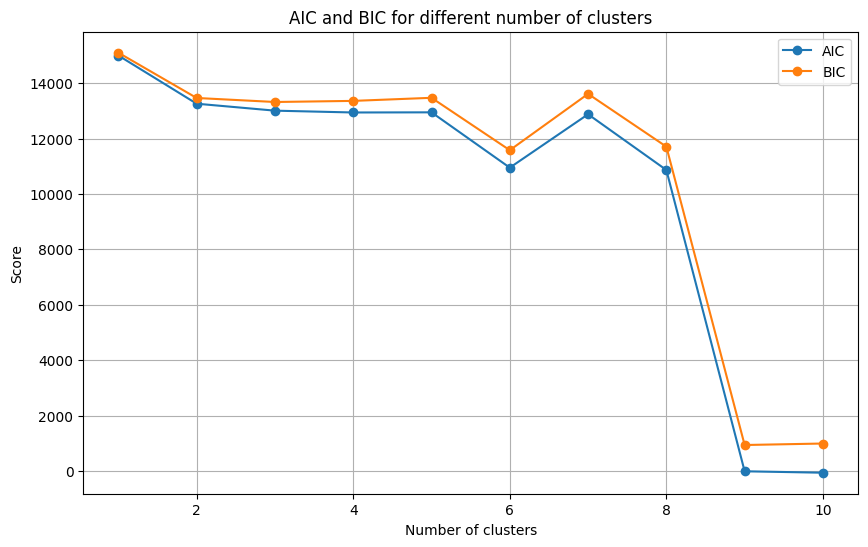

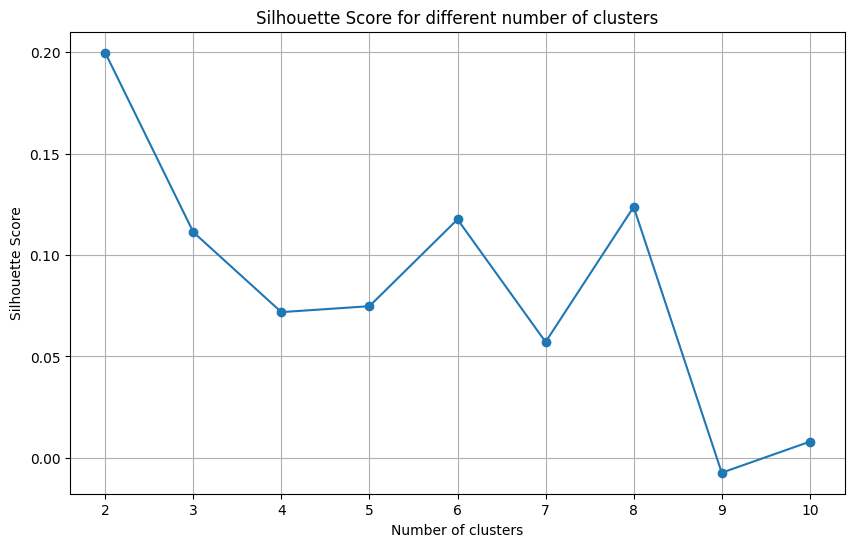

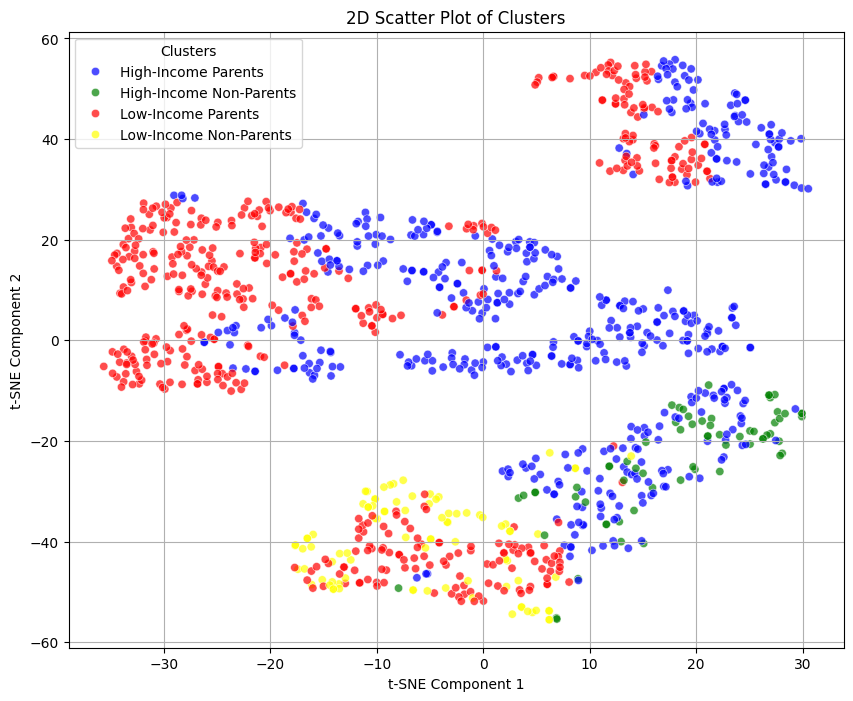

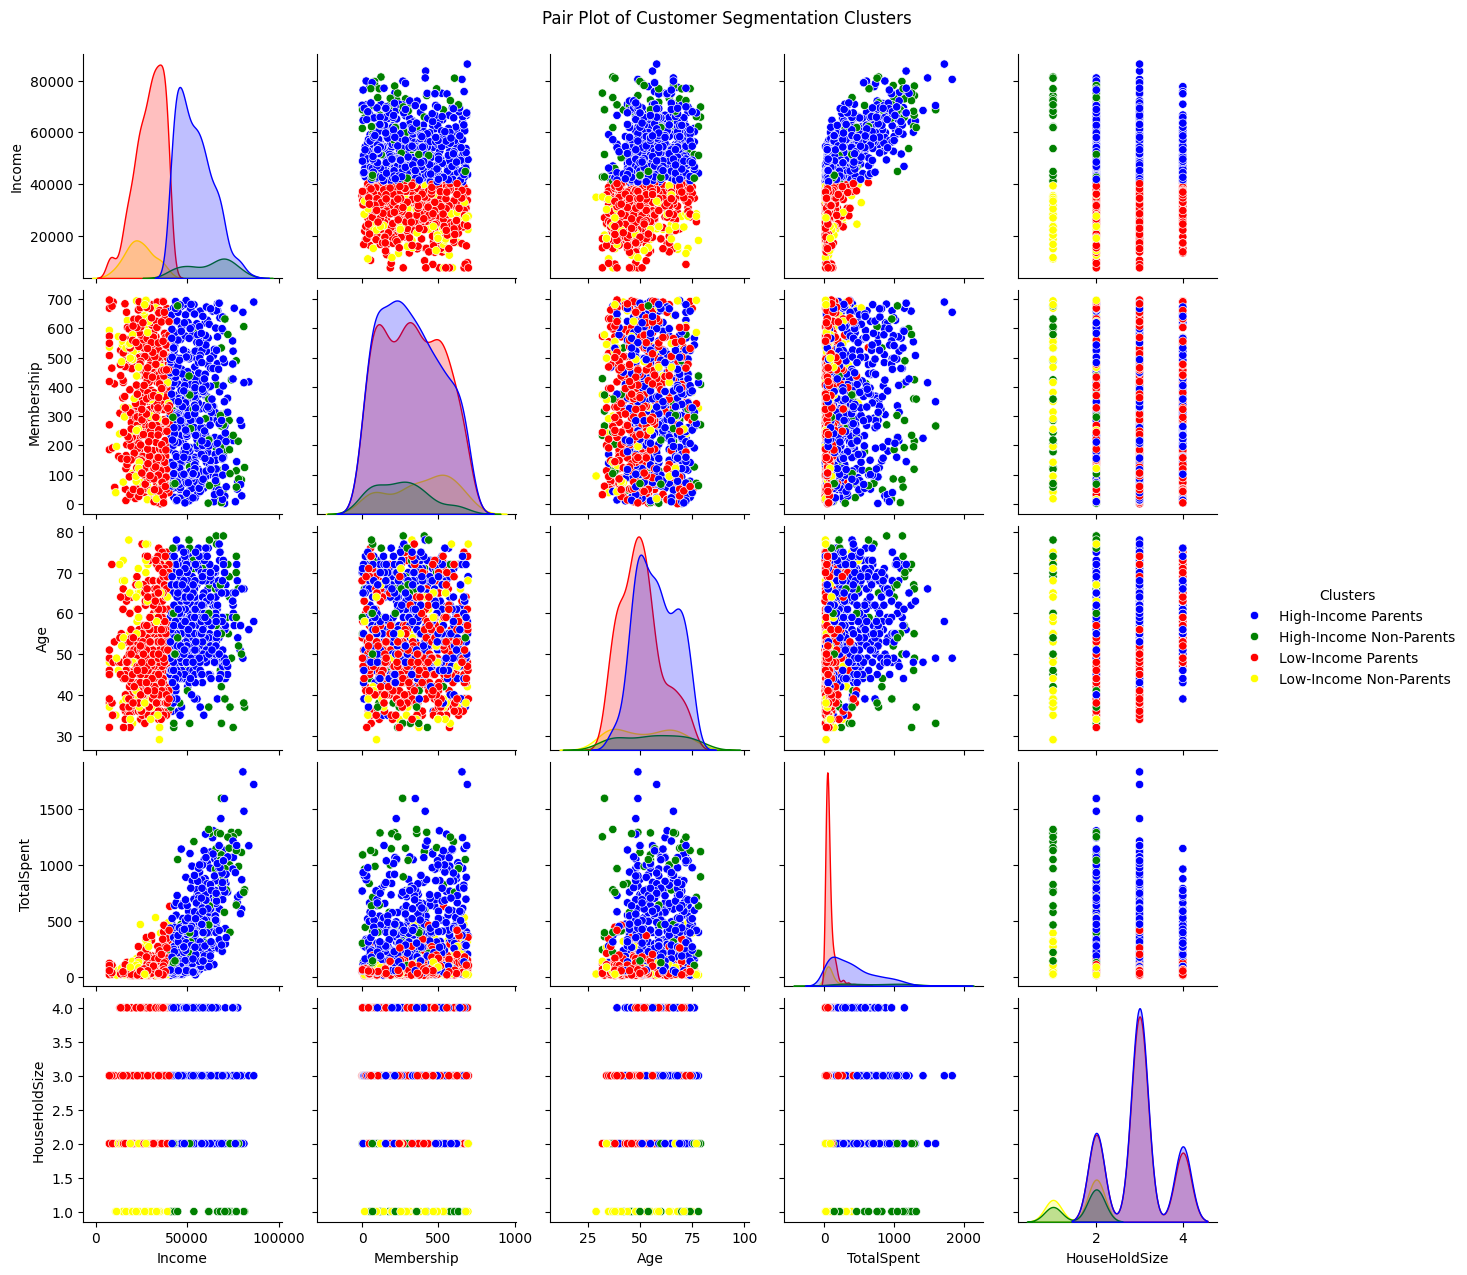

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE




# Load the dataset
df_cust = pd.read_csv('/content/Cleaned_CustomerPersonalityData.csv')
df_cust.head()


df_cust.shape
df_cust.dtypes
df_num = df_cust.drop(['Education', 'RelationshipStatus'], axis = 1)
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize=(15, 8))
for variable, subplot in zip(df_num.columns, ax.flatten()):
    sns.boxplot(df_cust[variable], ax = subplot)
plt.show()

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)

IQR = Q3 - Q1
df_num = df_num[~((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any(axis=1)]
df_num.shape

Total = df_num.isnull().sum().sort_values(ascending = False)
Percent = (df_num.isnull().sum()*100/df_num.isnull().count()).sort_values(ascending = False)

missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])
missing_data

df_num.dtypes

##Heirarchical

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_num)
link_mat = linkage(features_scaled, method = 'ward')
print(link_mat[0:10])

dendro = dendrogram(link_mat)
for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):

    x = sum(i[1:3])/2

    y = d[1]

    if y > 20:

        plt.plot(x, y, 'o', c=c)
        plt.annotate("%.3g" % y, (x, y), xytext=(0, -5), textcoords='offset points', va='top', ha='center')

plt.axhline(y = 100)

plt.title('Dendrogram', fontsize = 15)
plt.xlabel('Index', fontsize = 15)
plt.ylabel('Distance', fontsize = 15)
plt.show()


clusters = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters.fit(features_scaled)
df_num['Cluster'] = clusters.labels_
df_num.head()

df_num['Cluster'].value_counts()
sns.countplot(data = df_num, x = 'Cluster')
plt.title('Size of Cluster', fontsize = 15)
plt.xlabel('Cluster', fontsize = 15)
plt.ylabel('No. of Products', fontsize = 15)
plt.show()

# Perform PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_scaled)

# Create a DataFrame with PCA results and cluster labels
df_pca = pd.DataFrame(pca_features, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = clusters.labels_

# Plot the scatter plot with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=100, alpha=0.7, edgecolor='k')
plt.title('Customer Segments (PCA-Reduced Dimensions)', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.show()
df_num[df_num.Cluster==0].describe()
df_num[df_num.Cluster==1].describe()


##Kmeans

# Select relevant features for KMeans clustering
X_filtered = df_num[['Income', 'Recency', 'Wines', 'TotalSpent', 'Age']]
X_filtered.head()

# Normalize the selected features
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_filtered)
X = pd.DataFrame(X_norm, columns=X_filtered.columns)
X.head()

# Calculate WCSS for KMeans to determine the optimal number of clusters
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Plot', fontsize=15)
plt.xlabel('Number of clusters (K)', fontsize=15)
plt.ylabel('WCSS', fontsize=15)
plt.axvline(x=5, color='r', linestyle='--')  # Adjust if a different elbow point is observed
plt.show()

# Set KMeans with the chosen number of clusters (example K=5)
kmeans = KMeans(n_clusters=5, random_state=10)
kmeans.fit(X)
df_num['Cluster'] = kmeans.labels_

# Visualize cluster sizes
plt.figure(figsize=(8, 5))
sns.countplot(data=df_num, x='Cluster', palette='Set1')
plt.title('Size of Each Cluster', fontsize=15)
plt.xlabel('Cluster', fontsize=15)
plt.ylabel('Number of Customers', fontsize=15)

# Annotate count values on top of each bar
for i, count in enumerate(np.unique(kmeans.labels_, return_counts=True)[1]):
    plt.text(i, count + 2, str(count), ha='center', fontsize=12)

plt.show()

# Visualize KMeans clusters with a scatter plot using 'Income' vs. 'TotalSpent'
sns.lmplot(x='Income', y='TotalSpent', data=df_num, hue='Cluster',
           palette='Set1', markers=['o', 's', '^', 'p', 'D'], fit_reg=False, height=6, aspect=1.5)
plt.title('K-means Clustering (K=5)', fontsize=15)
plt.xlabel('Income', fontsize=15)
plt.ylabel('Total Spent', fontsize=15)
plt.show()
df_num[df_num.Cluster==0].describe()
df_num[df_num.Cluster==1].describe()


####GMM

# Select features for clustering
features = ['Income', 'Membership', 'Age', 'TotalSpent', 'HouseHoldSize']
X = df_num[features]


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Find best number of clusters using AIC and BIC
aic_values = []
bic_values = []
silhouette_scores = []
n_components_range = range(1, 11)


for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)

    aic_values.append(gmm.aic(X_scaled))
    bic_values.append(gmm.bic(X_scaled))
    if n_components > 1:
        silhouette_avg = silhouette_score(X_scaled, labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(None)


# Plot AIC and BIC
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, aic_values, label='AIC', marker='o')
plt.plot(n_components_range, bic_values, label='BIC', marker='o')
plt.title('AIC and BIC for different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range[1:], silhouette_scores[1:], label='Silhouette Score', marker='o')  # Start from 2 clusters
plt.title('Silhouette Score for different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


# Fit the GMM model with best number of clusters
optimal_components = 4
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
labels = gmm.predict(X_scaled)
df_num['Cluster'] = labels


# Limit of Income
income_threshold = df_num['Income'].median()
age_threshold = 65

def assign_cluster_labels(row):
    if row['Income'] > income_threshold:
        if row['Parent']:
            return 'High-Income Parents'
        else:
            return 'High-Income Non-Parents'
    else:
        if row['Parent']:
            return 'Low-Income Parents'
        else:
            return 'Low-Income Non-Parents'


# Create custom color palette
custom_palette = {'High-Income Parents': 'blue', 'Low-Income Parents': 'red', 'High-Income Non-Parents': 'green', 'Low-Income Non-Parents': 'yellow'}
# Assigning cluster labels
df_num['Clusters'] = df_num.apply(assign_cluster_labels, axis=1)

# Use t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
df_num['TSNE-1'] = X_tsne[:, 0]
df_num['TSNE-2'] = X_tsne[:, 1]

# Create a 2D scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue='Clusters', data = df_num, palette = custom_palette, alpha=0.7)

plt.title("2D Scatter Plot of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Clusters')
plt.grid()
plt.show()

# Plot Pairplot
sns.pairplot(df_num, vars=features, hue='Clusters', palette=custom_palette)
plt.suptitle("Pair Plot of Customer Segmentation Clusters", y=1.02)
plt.show()

